# Aging aware training

$$ \min_\theta \quad \int_{t=0}^{1} \; L(\theta(t)) \; dt $$
where  $\theta(t)$ is a fitted model of the conductance over time

## Monte Carlo approximation:

### Introduction

The goal is to integrate the following formular
$$
\int_t f(t){\rm d}t
$$
Rectangular approximation is 
$$
\sum_n f[n\Delta k]\Delta k
$$
The problem is that, if the sampling rate is lower than twice the frequencce of the function, the error would be large, e.g., integrating a $f(t)=\sin(2\pi (t+\frac{1}{4}))$ with sampling rate $\Delta k=1$, i.e.,
$$
\int_tf(t){\rm d}t\approx\sum_n \sin \left(2\pi (n+\frac{1}{4})\right)=n,
$$
which is obviously wrong.

### Monte Carlo Approximation

Recall the definition of **Expectation** of a distribution
$$
\begin{align}
\mathbb{E}\{x\}&=\int_x x\cdot p(x) {\rm d}x\\&\approx \frac{1}{N}\sum_{n=1}^N x_n,\ x_n\sim p(x)
\end{align}
$$
Further, 
$$
\begin{align}
\mathbb{E}\{f(x)\}&=\int_x f(x)\cdot p(x) {\rm d}x\\&\approx \frac{1}{N}\sum_{n=1}^N f(x_n),\ x_n\sim p(x)
\end{align}
$$
For a given integration task $\int_x f(x) {\rm d}x$, we can approximate this by
$$
\int_x f(x) {\rm d}x=\int_x f(x)\cdot 1 {\rm d}x=\int_x f(x)\cdot \frac{p(x)}{p(x)} {\rm d}x=\int_x\frac{f(x)}{p(x)}\cdot p(x) {\rm d}x=\mathbb{E}\left\{\frac{f(x)}{p(x)}\right\}\approx\frac{1}{N}\sum_{n=1}^N \frac{f(x_n)}{p(x_n)},\ x_n\sim p(x)
$$
Let $p(x)$ is a uniform distribution, e.g., $p(x)=\frac{1}{b-a},\ x\in[a,b]$, we have
$$
\int_x f(x) {\rm d}x\approx\frac{1}{N}\sum_{n=1}^N \frac{f(x_n)}{p(x_n)}=\frac{b-a}{N}\sum_{n=1}^N f(x_n),\ x\sim p(x).
$$
Let $b=1$ and $a=0$, 
$$
\int_x f(x) {\rm d}x\approx\frac{1}{N}\sum_{n=1}^N f(x_n),\ x\sim p(x),
$$
i.e., we can approximate the integration by averaging the randomly sampled value $f(x)$, with $x$ following uniform distribution.

Moreover, the method in the introduction is a special case of Monte Carlo method.
## Aging Aware Training

The goal of aging aware training is
$$
\min_{\theta_{\rm init}} \int_{t=0}^1 L(\theta(t)){\rm d}t,
$$
where $\theta(t)=\theta_{\rm init}\cdot\mathop{A}(t)$ denotes the aging of the resistors. Using Monto Carlo method, it is converted to
$$
\min_{\theta_{\rm init}} \frac{1}{K}\sum_{k\in \mathfrak{K} } L \left(\theta[k]\right),
$$
where $\mathfrak{K}$ is a set of $K$ uniform randomly sampled timestamps $k\in[0,1]$.

To minimize this function, i.e., $\frac{1}{N}\sum_{k\in \mathfrak{K} } L \left(\theta[k]\right)$, we apply intuitively the gradient descent:
$$
\begin{align}
\theta_{\rm init}&:=\theta_{\rm init} - \alpha\cdot\nabla_{\theta_{\rm init}}\left(\frac{1}{K}\sum_{k\in \mathfrak{K} } L \left(\theta[k]\right)\right)\\
&=\theta_{\rm init} - \frac{\alpha}{K}\cdot\nabla_{\theta_{\rm init}}\left(\sum_{k\in \mathfrak{K} } L \left(\theta[k]\right)\right)\\
&=\theta_{\rm init} - \frac{\alpha}{K}\cdot \sum_{k\in \mathfrak{K} } \nabla_{\theta_{\rm init}}\left(L \left(\theta[k]\right)\right)\\
\end{align}
$$

# Get aging model

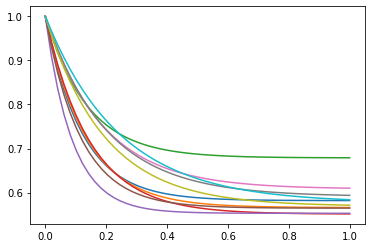

In [1]:
import pickle
import pNN_aging_aware as pnn
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import data
sys.path.append(os.path.join(os.getcwd(), 'Aging_Model'))
import torch
from torch.autograd import Variable
import torch.nn.functional as F

with open(os.path.join(os.getcwd(), 'Aging_Model', 'exp_aging_model.p'), 'rb') as f:
    age_generator = pickle.load(f)
vals = np.linspace(0,1)
age_models = age_generator.get_models(10)
for k in age_models:
    plt.plot(vals, k(vals));

## Prepare data

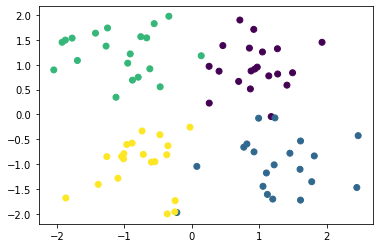

(torch.Size([80, 2]), torch.Size([80]))

In [28]:
X, Y = data.GenerateData(var=0.5, plot=True)
X, Y = X.T, Y.T.flatten()
x, y = torch.from_numpy(X).type(torch.FloatTensor), torch.from_numpy(Y).type(torch.LongTensor)
x, y = Variable(x), Variable(y)
x.shape, y.shape

## Try to get aged theta

In [3]:
import importlib
importlib.reload(pnn)

# generate NN, the initial time, i.e., pnn.PNNLayer.t = 0.
mypnn = torch.nn.Sequential(pnn.PNNLayer(2,5, age_generator),
                            pnn.PNNLayer(5,5, age_generator),
                            pnn.PNNLayer(5,4, age_generator))
counter = 1
for i in mypnn:
    print(f"The {counter}-th layer:")
    counter += 1
    
    print(f"theta at t={i.t}\n", i.theta_aged)    # print theta
    i.t = 0.1         # change time
    print(f"theta at t={i.t}\n", i.theta_aged)    # print aged theta
    
    print("\n")

The 1-th layer:
theta at t=0
 tensor([[ 0.4594,  0.4786, 19.2628, 88.0114],
        [ 0.9543,  0.3594,  5.4694, 24.1658],
        [ 0.9727,  0.0955,  1.2245,  4.6513],
        [ 0.7928,  0.4915,  6.1924, 27.6478],
        [ 0.8046,  0.6612, 19.3141, 87.9018]], grad_fn=<ViewBackward>)
theta at t=0.1
 tensor([[ 0.3885,  0.3986, 15.5927, 61.1767],
        [ 0.7449,  0.3014,  4.4759, 18.9949],
        [ 0.8438,  0.0730,  0.9725,  3.7168],
        [ 0.6193,  0.4070,  4.9660, 20.2226],
        [ 0.6717,  0.5147, 15.0943, 69.7278]], grad_fn=<ViewBackward>)


The 2-th layer:
theta at t=0
 tensor([[5.5012e-01, 7.8118e-01, 2.0611e-01, 9.8999e-01, 4.2421e-01, 1.9345e+01,
         8.6322e+01],
        [8.6695e-01, 7.1400e-01, 6.4517e-01, 3.1232e-01, 6.4546e-01, 2.0051e+01,
         8.9553e+01],
        [7.0327e-01, 5.0526e-01, 9.8711e-01, 7.4219e-01, 2.3902e-01, 4.5522e+00,
         1.7970e+01],
        [8.2656e-01, 9.3524e-02, 2.5786e-01, 5.5277e-02, 9.7537e-01, 1.3436e+01,
         6.0476e+01],


# Definations

In [4]:
MyAgedPNN = torch.nn.Sequential(pnn.PNNLayer(2,5, age_generator),
                                pnn.PNNLayer(5,5, age_generator),
                                pnn.PNNLayer(5,4, age_generator))
alpha = 0.001
m = 0.5
T = 0.1
K = 20
optimizer_aged = torch.optim.Adam(MyAgedPNN.parameters(), lr=0.01/K)
MyAgedPNN

Sequential(
  (0): PNNLayer()
  (1): PNNLayer()
  (2): PNNLayer()
)

In [5]:
MyPNN = torch.nn.Sequential(pnn.PNNLayer(2,5, age_generator),
                            pnn.PNNLayer(5,5, age_generator),
                            pnn.PNNLayer(5,4, age_generator))
optimizer = torch.optim.Adam(MyPNN.parameters(), lr=alpha)
MyPNN

Sequential(
  (0): PNNLayer()
  (1): PNNLayer()
  (2): PNNLayer()
)

In [6]:
for s in range(2000):
    optimizer.zero_grad()
    
    prediction = MyPNN(x)
    loss = pnn.LossFunction(prediction, y, m, T)
    loss.backward()
    
    optimizer.step()

    if s % 100 == 0:
        p = torch.max(F.softmax(prediction, dim=0), 1)[1]
        pred_y = p.data.numpy().squeeze()
        print('Accuracy is: ', sum(pred_y == Y) / Y.shape[0]) # (TP + FN)
        print('Loss is: ', loss.data)
print('Finished.')

Accuracy is:  0.2
Loss is:  tensor(1.1776)
Accuracy is:  0.4875
Loss is:  tensor(1.1112)
Accuracy is:  0.725
Loss is:  tensor(1.0627)
Accuracy is:  0.825
Loss is:  tensor(1.0279)
Accuracy is:  0.8625
Loss is:  tensor(0.9867)
Accuracy is:  0.8625
Loss is:  tensor(0.9382)
Accuracy is:  0.85
Loss is:  tensor(0.8934)
Accuracy is:  0.85
Loss is:  tensor(0.8498)
Accuracy is:  0.875
Loss is:  tensor(0.8179)
Accuracy is:  0.925
Loss is:  tensor(0.7984)
Accuracy is:  0.925
Loss is:  tensor(0.7799)
Accuracy is:  0.95
Loss is:  tensor(0.7623)
Accuracy is:  0.9625
Loss is:  tensor(0.7479)
Accuracy is:  0.975
Loss is:  tensor(0.7333)
Accuracy is:  1.0
Loss is:  tensor(0.7198)
Accuracy is:  1.0
Loss is:  tensor(0.7078)
Accuracy is:  1.0
Loss is:  tensor(0.6955)
Accuracy is:  1.0
Loss is:  tensor(0.6839)
Accuracy is:  1.0
Loss is:  tensor(0.6745)
Accuracy is:  1.0
Loss is:  tensor(0.6658)
Finished.


In [7]:
# P = []
# for i in MyPNN:
#     P.append(i.theta_.data)
# for i, j in enumerate(MyAgedPNN):
#     j.theta_ =  torch.nn.Parameter(P[i], requires_grad=True)

In [12]:
for s in range(1500):
    optimizer_aged.zero_grad()
    
    TimeSet = np.random.rand(K)
    for k in TimeSet:
        for i in MyAgedPNN:
            i.t = k
        prediction = MyAgedPNN(x)
        loss = pnn.LossFunction(prediction, y, m, T)
        loss.backward()
    
    optimizer_aged.step()

    if s % 100 == 0:
        test_loss = 0
        test_acc = 0
        
        test_time = np.linspace(0,1,100)
        for test_t in test_time:
            for i in MyAgedPNN:
                i.t = test_t
            prediction = MyAgedPNN(x)
            loss = pnn.LossFunction(prediction, y, m, T)
            p = torch.max(F.softmax(prediction, dim=0), 1)[1]
            pred_y = p.data.numpy().squeeze()
            acc = sum(pred_y == Y) / Y.shape[0]

            test_loss += loss.data
            test_acc += acc
        
        test_loss /= 100
        test_acc /= 100
        
        print(f'{s:-6d} |Accuracy: {test_acc:.5f}\t|Loss: {test_loss:.5f}')

print('Finished.')

0	|Accuracy: 0.7722500000000003	|Loss: 0.8287551999092102
100	|Accuracy: 0.79025	|Loss: 0.8178808689117432
200	|Accuracy: 0.8178750000000008	|Loss: 0.8095529079437256
300	|Accuracy: 0.841500000000001	|Loss: 0.8015608787536621
400	|Accuracy: 0.8613749999999996	|Loss: 0.7798901200294495
500	|Accuracy: 0.8658749999999997	|Loss: 0.7599697113037109
600	|Accuracy: 0.8729999999999996	|Loss: 0.7505819201469421
700	|Accuracy: 0.9158750000000001	|Loss: 0.7428749799728394
800	|Accuracy: 0.92925	|Loss: 0.7351632714271545
900	|Accuracy: 0.9460000000000016	|Loss: 0.7264611721038818
1000	|Accuracy: 0.9537500000000024	|Loss: 0.7158549427986145
1100	|Accuracy: 0.9625000000000012	|Loss: 0.7059671878814697
1200	|Accuracy: 0.9626250000000012	|Loss: 0.6946538686752319
1300	|Accuracy: 0.9627500000000012	|Loss: 0.6795160174369812
1400	|Accuracy: 0.9628750000000013	|Loss: 0.6640354990959167
Finished.


In [26]:
import accuracy_codes as ac
import importlib
importlib.reload(ac)

test_time = np.linspace(0,1,100)
my_aged_acc = []
my_aged_loss = []
my_acc = []
my_loss = []
my_temp = []
my_aged_temp = []

for test_t in test_time:
    for i in MyAgedPNN:
        i.t = test_t
    prediction = MyAgedPNN(x)
    loss = pnn.LossFunction(prediction, y, m, T)
    p = torch.max(F.softmax(prediction, dim=0), 1)[1]
    pred_y = p.data.numpy().squeeze()
    acc = sum(pred_y == Y) / Y.shape[0]
    temp = ac.basic_accuracy(MyAgedPNN, x, y)
    
    my_aged_loss.append(loss.data)
    my_aged_acc.append(acc)
    my_aged_temp.append(temp)

for test_t in test_time:
    for i in MyPNN:
        i.t = test_t
    prediction = MyPNN(x)
    loss = pnn.LossFunction(prediction, y, m, T)
    p = torch.max(F.softmax(prediction, dim=0), 1)[1]
    pred_y = p.data.numpy().squeeze()
    acc = sum(pred_y == Y) / Y.shape[0]
    temp = ac.basic_accuracy(MyPNN, x, y)
    
    my_loss.append(loss.data)
    my_acc.append(acc)
    my_temp.append(temp)

TypeError: Cannot interpret '-1' as a data type

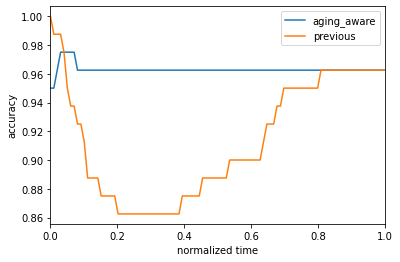

In [14]:
plt.plot(test_time, my_aged_acc, label='aging_aware');
plt.plot(test_time, my_acc, label='previous');
plt.xlabel('normalized time');
plt.ylabel('accuracy');
plt.xlim([0, 1])
plt.legend();

In [25]:
torch

<module 'torch' from '/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/torch/__init__.py'>